In [441]:
import numpy as np
import pickle as cp

In [442]:
# Empty model

class EmptyModel:
    def log_prob(self, data):
        return 0
    
    def __str__(self):
        return 'empty-model'

In [443]:
# Multinomial model

class MultinomialModel:
    def __init__(self, data, labels):
        n = len(data) + len(labels)
        curr_labels, counts = np.unique(data, return_counts=True)
        log_probs = np.log(counts + 1) - np.log(n)
        self.class_log_probs = dict(zip(curr_labels, log_probs))
        for lab in labels:
            if not lab in self.class_log_probs:
                self.class_log_probs[lab] =  - np.log(n)
        
        def lookup_one(lab):
            if lab in self.class_log_probs: return self.class_log_probs[lab]
            else: return 0
        self.lookup = np.vectorize(lookup_one)
        
    def log_prob(self, data):
        return self.lookup(data)
    
    def __str__(self):
        return 'multinomial-model(' + str(self.class_log_probs) + ')'

In [444]:
# Gausian model

class GausianModel:
    def __init__(self, data):
        data = np.vectorize(float)(data)
        self.mean = np.mean(data)
        std = np.std(data)
        self.var = max(std ** 2, 1e-6)
        self.scale = - np.log(2 * np.pi * self.var) / 2
        
    def log_prob(self, data):
        data = np.vectorize(float)(data)
        return ( - (data - self.mean) ** 2 / (2 * self.var)) + self.scale
    
    def __str__(self):
        return 'gaussian-model(' + str(self.mean) + ', ' + str(self.var) + ')'

In [445]:
# Naive Bayes classifier

class NBC:
    def __init__(self, feature_types, missing=[]):
        self.feature_types = feature_types
        self.missing = missing
    
    def get_feature_prob(self, feature, label):
        model = models_by_class
    
    def fit(self, X, y):
        # set class probabilities
        labels, counts = np.unique(y, return_counts=True)
        log_probs = np.log(counts) - np.log(len(y))
        self.class_log_probs = dict(zip(labels, log_probs))
        self.labels = labels
        missing = self.missing
        
        # split data by classes
        X_by_class = dict()
        for lab in labels:
            indices = np.where(y == lab)[0]
            X_by_class[lab] = np.take(X, indices, axis=0)
        
        # find feature classes
        num_features = len(self.feature_types)
        feature_lables = dict()
        for i in range(num_features):
            if self.feature_types[i] != 'n' and self.feature_types[i] != 'r':
                data = X[:, i]
                if len(missing) > i:
                    ms = missing[i]
                    data = data[data != ms]
                feature_lables[i] = np.unique(data)
        
        # fit models
        self.models = dict()
        for lab in labels:
            self.models[lab] = dict()
            for i in range(num_features):
                data = X_by_class[lab][:, i]
                if len(missing) > i:
                    ms = missing[i]
                    data = data[data != ms]
                if self.feature_types[i] == 'n':
                    model = EmptyModel()
                elif self.feature_types[i] == 'r':
                    model = GausianModel(data)
                else:
                    model = MultinomialModel(data, feature_lables[i])
                self.models[lab][i] = model
    
    def predict(self, X):
        n = len(self.feature_types)
        def get_lab_log_prob(lab):  
            models = self.models[lab]
            def get_feature_log_prob(i):
                return models[i].log_prob(X[:, i])
            flps = np.array(list(map(get_feature_log_prob, np.arange(n))))
            return np.sum(flps, axis=0) + self.class_log_probs[lab]
        lab_log_probs = np.array(list(map(get_lab_log_prob, self.labels)))
        lab_idxs = np.argmax(lab_log_probs, axis=0)
        return self.labels[lab_idxs]

In [446]:
# Shuffle a dataset

def shuffle_dataset(X, y):
    N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    return Ntrain, Xtrain, ytrain, Xtest, ytest

In [447]:
# Find learning curve

intervals = 10

def learning_curve_round(model, X, y):
    Ntrain, Xtrain, ytrain, Xtest, ytest = shuffle_dataset(X, y)
    result = list()
    for i in range(intervals):
        N = int(Ntrain * (i + 1) / intervals)
        model.fit(Xtrain[:N], ytrain[:N])
        yhat = model.predict(Xtest)
        test_error = np.mean(yhat != ytest)
        result.append(test_error)
    return np.array(result)

def learning_curve(model, X, y, iters=200):
    result = list()
    for i in range(iters):
        result.append(learning_curve_round(model, X, y))
    return np.mean(np.array(result), axis=0)

In [448]:
# Plot learning curves

import matplotlib.pyplot as plt

def plot_learning_curves(title, models, X, y, iters=200):
    xs = (np.arange(intervals) + 1) * 100 / intervals
    for model in models:
        plt.plot(xs, learning_curve(model, X, y, iters))
    plt.title(title)
    plt.show()

In [449]:
# Logistic regression classifier

from sklearn.linear_model import LogisticRegression

lrc = LogisticRegression(C=5.0, multi_class='ovr', solver='liblinear')

In [450]:
# Load iris dataset

from sklearn.datasets import load_iris

def load_iris_dataset():
    iris = load_iris()
    return iris['data'], iris['target']

In [451]:
# Load voting dataset

def load_voting_dataset():
    return cp.load(open('voting.pickle', 'rb'))

def load_full_voting_dataset():
    return cp.load(open('voting_full.pickle', 'rb'))

In [466]:
# Load adult dataset

def load_adult_dataset():
    return cp.load(open('adult.pickle', 'rb'))

def load_full_adult_dataset():
    return cp.load(open('adult_full.pickle', 'rb'))

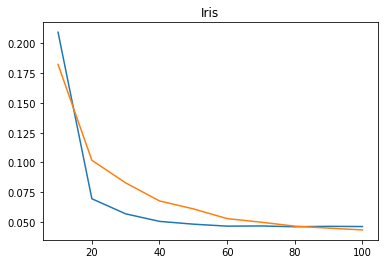

In [453]:
X, y = load_iris_dataset()
nbc = NBC(feature_types='rrrr')
plot_learning_curves('Iris', [nbc, lrc], X, y)

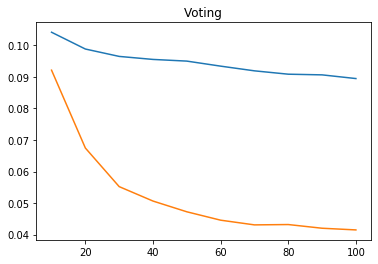

In [454]:
X, y = load_voting_dataset()
nbc = NBC(feature_types='bbbbbbbbbbbbbbbb')
plot_learning_curves('Voting', [nbc, lrc], X, y)

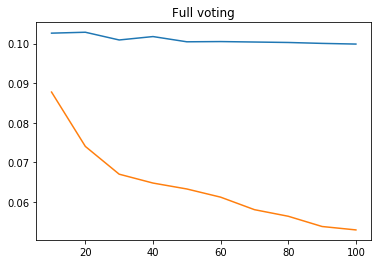

In [455]:
X, y = load_full_voting_dataset()
nbc = NBC(feature_types='bbbbbbbbbbbbbbbb', missing=np.repeat(2, 16))
plot_learning_curves('Full voting', [nbc, lrc], X, y)

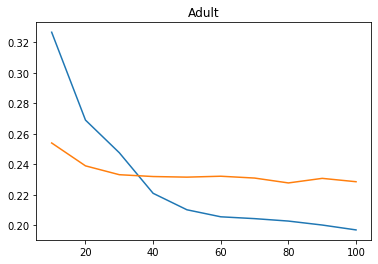

In [487]:
X , y = load_adult_dataset()
X = X[:500]
y = y[:500]
nbc = NBC(feature_types='rcrcrcccccrrrc')
plot_learning_curves('Adult', [nbc, lrc], X, y, iters=50)

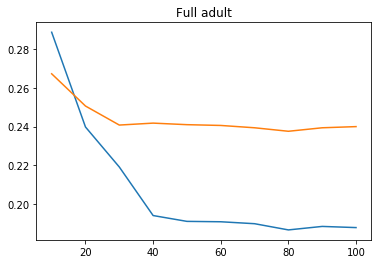

In [488]:
X , y = load_full_adult_dataset()
X = X[:500]
y = y[:500]
nbc = NBC(feature_types='rcrcrcccccrrrc', missing=np.repeat(-1, 16))
plot_learning_curves('Full adult', [nbc, lrc], X, y, iters=50)